
##Data 6100 - Final Project : Recipe Classification

Chathushi Thalpage (1358582)



### Data Loading
- Import necessary libraries for modeling and analysis
- Load training and test data JSON files.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, classification_report
from collections import Counter
from google.colab import drive, files

drive.mount('/content/drive')
# Load datasets (ensure train.json and test.json are in your working directory)
train = pd.read_json("/content/drive/MyDrive/Colab Notebooks/train.json")
test = pd.read_json("/content/drive/MyDrive/Colab Notebooks/test.json")

# Basic checks
print("Train shape:", train.shape)
print("Test shape:", test.shape)

print("\nTrain columns:", train.columns.tolist())
print("Test columns:", test.columns.tolist())

# Look at first few rows
train.head()


Mounted at /content/drive
Train shape: (39774, 3)
Test shape: (9944, 2)

Train columns: ['id', 'cuisine', 'ingredients']
Test columns: ['id', 'ingredients']


,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


###Identifying Missing Values
 - No missing values were identified in both train and test sets

In [ ]:
print("\nMissing values in train:")
print(train.isnull().sum())

print("\nMissing values in test:")
print(test.isnull().sum())


Missing values in train:
id             0
cuisine        0
ingredients    0
dtype: int64

Missing values in test:
id             0
ingredients    0
dtype: int64


###Exploratory Data Analysis

**Cuisine distribution**

The cuisine distribution plot shows moderate class imbalance, where cuisines such as Italian, Mexican, and Southern US have several thousand examples, while others like Brazilian, Irish, and Jamaican have only a few hundred. Although the imbalance is noticeable, it is not extreme. Even the smallest classes still contain over 300 training samples.

In text classification tasks, the presence of distinctive words (e.g., "garam masala", "fish sauce", "soy sauce", "curry leaves") provides very strong signals for separating classes. Because each cuisine has unique ingredient markers, the model can learn good decision boundaries even with uneven class sizes.

Therefore, moderate imbalance does not significantly harm model performance in this dataset.

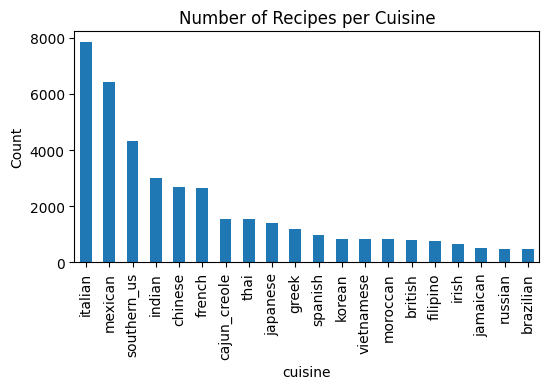

In [ ]:
# Cuisine distribution

plt.figure(figsize=(6,3))
train['cuisine'].value_counts().plot(kind='bar')
plt.title("Number of Recipes per Cuisine")
plt.ylabel("Count")
plt.show()

Top 20 most common ingredients

- Ingredients like salt, onions, olive oil, water, garlic, sugar appear in almost every cuisine.

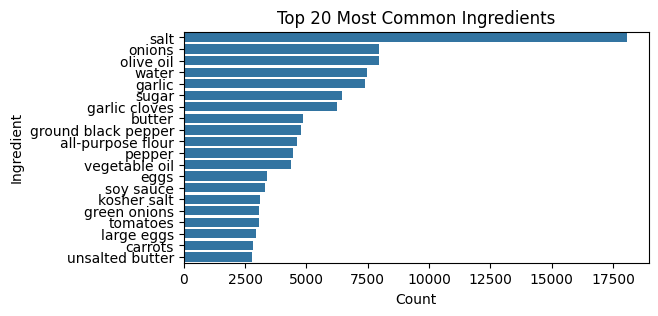

In [ ]:
# Flatten all ingredient lists
all_ingredients = [ingredient for recipe in train['ingredients'] for ingredient in recipe]

ingredient_counts = Counter(all_ingredients)
common_ingredients = ingredient_counts.most_common(20)

common_ingredients_df = pd.DataFrame(common_ingredients, columns=['ingredient', 'count'])

plt.figure(figsize=(6,3))
sns.barplot(data=common_ingredients_df, x='count', y='ingredient')
plt.title("Top 20 Most Common Ingredients")
plt.xlabel("Count")
plt.ylabel("Ingredient")
plt.show()

### Preprocessing Experiments (Not Used in Final Model)

Before selecting the final preprocessing pipeline, I experimented with several text cleaning and feature engineering strategies to see whether they could improve model performance. These experiments were performed separately and later removed from the final pipeline because they did not increase validation accuracy.

1. Joining Multi Word Ingredients with Underscores

Observation:
Validation accuracy dropped significantly (from 77% down to 73%).
This is because tokens such as "soy sauce" were merged into "soy_sauce", removing informative unigrams like "soy" and "sauce" that TF-IDF weighs effectively.

2. Removing Common Ingredients (salt, water, oil, sugar, etc.)

Observation:
Accuracy decreased.
Even though these ingredients are common, their relative frequencies still carry signal across cuisines. Removing them removed useful patterns.

3. Removing Measurement and Descriptor Words

Example: ["fresh", "chopped", "dried", "ground", "large", "small"]

Observation:
No improvement.
TF-IDF already downweights these frequent, non-informative words, so manually removing them did not help.

4. Synonym / Ingredient Normalization

Example:
["scallions": "green_onion",
    "spring_onions": "green_onion",
    "green_onions": "green_onion",
    "chickpeas": "chickpea",
    "dark_soy_sauce": "soy_sauce",]

Observation:
Accuracy slightly decreased.
Many rare ingredient variants (e.g., “scallions”, “spring onions”) contain subtle distributional information that helps distinguish cuisines. Normalizing them removed that signal.

**Conclusion**:

All preprocessing attempts other than lowercasing reduced model performance because they removed useful discriminative information and altered TF-IDF token statistics.

The best performing approach was the simplest one which converts list of ingredients into a single lowercase string. This achieved the highest validation accuracy (0.7715) and was used in the final model.

In [ ]:
# Preprocessing Block (Not Used in Final Model, Just for Experiments to Improve Performance)

# 1. Words that are not helpful for classification
measure_words = {
    "fresh", "chopped", "dried", "ground",
    "large", "small"
}

# 2. Very common base ingredients (little discriminative power)
stop_ingredients = {
    "salt", "water", "sugar"
}

# 3. Simple synonym / normalization mapping
normalize_map = {
    "scallions": "green_onion",
    "spring_onions": "green_onion",
    "green_onions": "green_onion",
    "garbanzo_beans": "chickpea",
    "chickpeas": "chickpea",
    "dark_soy_sauce": "soy_sauce",
}

def preprocess_ingredients(ingredients_list):
    # ingredients_list: list of strings from the JSON ['romaine lettuce', 'olive oil', ...] returns: cleaned string like 'romaine_lettuce grape_tomatoes soy_sauce ...'

    # join multi word ingredients using underscores and lowercase
    tokens = [ing.lower().replace(" ", "_") for ing in ingredients_list]

    # apply normalization map
    tokens_norm = [normalize_map.get(tok, tok) for tok in tokens]

    # remove measurement/descriptor words if they appear as standalone tokens
    tokens_no_meas = [tok for tok in tokens_norm if tok not in measure_words]

    # remove very generic stop ingredients
    tokens_final = [tok for tok in tokens_no_meas if tok not in stop_ingredients]

    # join back into a single text string
    return " ".join(tokens_final)

# Apply preprocessing to train & test
train["text"] = train["ingredients"].apply(preprocess_ingredients)
test["text"]  = test["ingredients"].apply(preprocess_ingredients)

# Quick sanity check
train[["ingredients", "text"]].head()


,ingredients,text
0,"[romaine lettuce, black olives, grape tomatoes...",romaine_lettuce black_olives grape_tomatoes ga...
1,"[plain flour, ground pepper, salt, tomatoes, g...",plain_flour ground_pepper tomatoes ground_blac...
2,"[eggs, pepper, salt, mayonaise, cooking oil, g...",eggs pepper mayonaise cooking_oil green_chilie...
3,"[water, vegetable oil, wheat, salt]",vegetable_oil wheat
4,"[black pepper, shallots, cornflour, cayenne pe...",black_pepper shallots cornflour cayenne_pepper...


###Final Preprocessing Used (join + lowercase)
- Converted ingredient lists into meaningful text input for TF-IDF.

- Extracted the ingredients list and joined tokens to form a raw text field per recipe.

- Converted all text to lowercase for normalization and consistent tokenization.
- Same preprocessing steps were applied to both training and test sets


In [ ]:
# Convert list of ingredients into a single lowercase string
train["text"] = train["ingredients"].apply(lambda x: " ".join(x).lower())
test["text"]  = test["ingredients"].apply(lambda x: " ".join(x).lower())

train[["ingredients", "text"]].head()

,ingredients,text
0,"[romaine lettuce, black olives, grape tomatoes...",romaine lettuce black olives grape tomatoes ga...
1,"[plain flour, ground pepper, salt, tomatoes, g...",plain flour ground pepper salt tomatoes ground...
2,"[eggs, pepper, salt, mayonaise, cooking oil, g...",eggs pepper salt mayonaise cooking oil green c...
3,"[water, vegetable oil, wheat, salt]",water vegetable oil wheat salt
4,"[black pepper, shallots, cornflour, cayenne pe...",black pepper shallots cornflour cayenne pepper...


### Train / Validation Split

To evaluate models fairly, a stratified 80/20 split was used:

- X_train, X_val: ingredient text

- y_train, y_val: cuisine labels

This allowed consistent comparison across all models.

This validation set is used throughout all model comparisons and hyperparameter tuning.


In [ ]:
X = train["text"]
y = train["cuisine"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(X_train.shape, X_val.shape)


(31819,) (7955,)


###TF-IDF Vectorization

1.TF-IDF vectorizer was used as the primary feature extraction method.

2.This converts the ingredient text into a sparse numerical vectors by :

Term Frequency (TF): Measuring how often an ingredient appears in a recipe

Inverse Document Frequency (IDF): Down weighting ingredients that appear in many recipes

3.Used parameters :
- ngram_range = (1, 1) (unigrams)

- min_df = 5 (ignore very rare ingredients)

- max_df = 0.9 (ignore extremely common terms)

- English stop words removed via built-in parameter

3.This produces high dimensional sparse matrices.

In [ ]:
# training TF-IDF and transform both train and val
tfidf = TfidfVectorizer(
    stop_words='english',
    max_df=0.90,
    min_df=5,
    ngram_range = (1, 1)
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf   = tfidf.transform(X_val)
X_test_tfidf  = tfidf.transform(test["text"])  # for later


###Model Training

1.Trained two models

- Logistic Regression :  a linear classification model that estimates the probability of each class by applying the logistic function to a weighted combination of input features. It is well suited for high-dimensional sparse data such as TF-IDF ingredient representations.

- Multinomial Naive Bayes: a probabilistic classifier commonly used for text data. It assumes that features (ingredients) contribute independently to the probability of each cuisine. It performs well as a fast baseline model for TF-IDF features.

2.TF-IDF vectors were used as input for all models

3.Both models were evaluated using Validation Accuracy : measures how well the model predicts the correct cuisine on a portion of the data that was set aside and not used during training. It provides an estimate of how well the model will perform on new, unseen data.

####Model 1 – Multinomial Naive Bayes



In [ ]:
nb_clf = MultinomialNB()
nb_clf.fit(X_train_tfidf, y_train)

y_val_pred_nb = nb_clf.predict(X_val_tfidf)
nb_acc = accuracy_score(y_val, y_val_pred_nb)

print("Naive Bayes validation accuracy:", nb_acc)

Naive Bayes validation accuracy: 0.6942803268384664


#### Model 2 – Logistic Regression

In [ ]:
lr_clf = LogisticRegression(
    C=1.0,
    max_iter=400,
    solver='lbfgs',
    multi_class='multinomial',
    n_jobs=-1
)

lr_clf.fit(X_train_tfidf, y_train)
y_val_pred_lr = lr_clf.predict(X_val_tfidf)

lr_acc = accuracy_score(y_val, y_val_pred_lr)
print("Logistic Regression (C=1) validation accuracy:", lr_acc)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression (C=1) validation accuracy: 0.7766184789440603


###Model Comparison Table

Logistic Regression clearly outperforms among two models and was selected as the primary model.




In [ ]:
results = {
    "Naive Bayes": nb_acc,
    "Logistic Regression (C=1)": lr_acc
}

results_df = pd.DataFrame.from_dict(results, orient='index', columns=["Validation Accuracy"])
results_df


,Validation Accuracy
Naive Bayes,0.694280
Logistic Regression (C=1),0.776618


###Hyperparameter Tuning – Logistic Regression

GridSearchCV was applied to Logistic Regression with 3 fold cross validation to evaluate different values of the regularization parameter C

Parameters tested:
- C = {0.5, 1, 2, 3, 5, 10}
- solver = 'lbfgs'
- multi_class = 'multinomial'
- max_iter = 400

The best cross-validated hyperparameter was: C = 5

In [ ]:
param_grid = {
"C": [0.5, 1, 2, 3, 5, 10]
}

logreg_base = LogisticRegression(
max_iter=400,
solver='lbfgs',
multi_class='multinomial',
n_jobs=-1
)

# Applying GridSearchCV with Cross Validation

grid = GridSearchCV(
estimator=logreg_base,
param_grid=param_grid,
cv=3,
scoring='accuracy',
n_jobs=-1,
verbose=2
)

grid.fit(X_train_tfidf, y_train)

print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)


Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best params: {'C': 5}
Best CV score: 0.7818599696635365


###Optimized Logistic Regression on Validation Split

- Optimized the model with selected params on the validation set.
- This model achieved the strongest validation accuracy: 0.7845

In [ ]:
best_C = grid.best_params_["C"]

logreg_opt = LogisticRegression(
C=best_C,
max_iter=400,
solver='lbfgs',
multi_class='multinomial',
n_jobs=-1
)

logreg_opt.fit(X_train_tfidf, y_train)
y_val_pred_opt = logreg_opt.predict(X_val_tfidf)

opt_val_acc = accuracy_score(y_val, y_val_pred_opt)
print(f"Optimized Logistic Regression (C={best_C}) validation accuracy:", opt_val_acc)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Optimized Logistic Regression (C=5) validation accuracy: 0.7845380263984915


###Final Model Training
Then I refit the best model (TF-IDF + Logistic Regression with C=5) on the **full training dataset**.

Steps:
1. Fit TF-IDF on full training text
2. Fit Logistic Regression
3. Predict cuisines for the test dataset
4. Prepare submission file for Kaggle



In [ ]:
# Refit TF-IDF on ALL train text
tfidf_final = TfidfVectorizer(
stop_words='english',
max_df=0.9,
min_df=5
)

X_full_tfidf = tfidf_final.fit_transform(train["text"])
X_test_final_tfidf = tfidf_final.transform(test["text"])

# Train final LR with best C
logreg_final = LogisticRegression(
C=best_C,
max_iter=400,
solver='lbfgs',
multi_class='multinomial',
n_jobs=-1
)

logreg_final.fit(X_full_tfidf, train["cuisine"])

# Predict on test set
test_pred = logreg_final.predict(X_test_final_tfidf)

#create submission file for kaggle
submission = pd.DataFrame({
    "id": test["id"],
    "cuisine": test_pred
})

submission.to_csv("submission.csv", index=False)
submission.head()
files.download("submission.csv")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>